# Setup

In [2]:
"""
Add parent directorys to current path
"""
import os.path
import sys
p = os.path.abspath('..')
if p not in sys.path:
    sys.path.insert(0,p)
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.insert(0,p)
    
    
"""
Add tiger-env directory to current path
Still not sure why this is needed.
"""
p = os.path.abspath('../../../custom_envs/gym-tiger')
if p not in sys.path:
    sys.path.insert(0, p)
    

"""
Enable hot-reloading
"""    
from notebook_utils import import_module_by_name, reload_module_by_name

def reload():
    reload_module_by_name('rlpomdp.models.tiger_env', 'QLearnerSeq')
    global QLearnerSeq
    from rlpomdp.models.tiger_env import QLearnerSeq

# Setup ENV and Model

In [11]:
import gym
import gym_tiger
import matplotlib.pyplot as plt
from rlpomdp.utils import play_one, plot_running_avg
from rlpomdp.models.tiger_env import QLearnerSeq

env = gym.make('Tiger-v0')
env.__init__(reward_tiger=-100, reward_gold=10, reward_listen=-1)
model = QLearnerSeq(env, initial_alpha=5, gamma=1, alpha_decay=.5, seq_len=3)
eps = 1
n = 0
ot = env.reset()

# Take one action and update Q

$$
Q(s_{t-1}, a_{t-1}) = Q(s_{t-1}, a_{t-1}) + \alpha \big[ r_t + \gamma \cdot Q(s_t, a_t) - Q(s_{t-1}, a_{t-1}) \big]
$$

In [5]:
print(str(model))
otm1 = ot
atm1 = model.sample_action(otm1, eps)
ot, r, done, info = env.step(atm1)
at = model.best_action(ot)
model.update(otm1, atm1, r, ot, at)
_otm1 = env.translate_obs(otm1)
_atm1 = env.translate_action(atm1)
print(_otm1, ',', _atm1, ',', r)
print(str(model))



                                                  OPEN LEFT | OPEN RIGHT | LISTEN
		------------------------------------------- | --------- | ----------  | ------


START , OPEN_LEFT , -100


                                                  OPEN LEFT | OPEN RIGHT | LISTEN
		------------------------------------------- | --------- | ----------  | ------
['START']                                             -10.0 |        0.0 |    0.0




# Play 1 Episode

In [8]:
print(str(model))
play_one(env, model, eps, verbose=True)
print(str(model))



                                                  OPEN LEFT | OPEN RIGHT | LISTEN
		------------------------------------------- | --------- | ----------  | ------
['START']                                             -10.0 |        0.0 |    0.0
['START', 'START']                                      0.0 |       -7.1 |    0.0
['START', 'START', 'START']                             0.6 |        0.0 |    0.0


o_t-n,...,o_t-1                          | o_t-1       | a_t-1      | r     | o_t         | a_t       
----------------------------------------------------------------------------------------------------
['START', 'START', 'START']              | START       | OPEN_RIGHT | 10    | END         | OPEN_LEFT 


                                                  OPEN LEFT | OPEN RIGHT | LISTEN
		------------------------------------------- | --------- | ----------  | ------
['START']                                             -10.0 |        0.0 |    0.0
['START', 'START']               

# Play 5K Episodes



                                                  OPEN LEFT | OPEN RIGHT | LISTEN
		------------------------------------------- | --------- | ----------  | ------
['START']                                              50.0 |        0.0 |    0.0
['START', 'START']                                     35.4 |        0.0 |    0.0
['START', 'START', 'START']                          -288.7 |     -250.0 |   -2.3
['START', 'START', 'GROWL_RIGHT']                     -65.5 |      -55.6 |   -3.1
['START', 'START', 'GROWL_LEFT']                     -204.1 |     -110.0 |   -2.1
['START', 'GROWL_RIGHT', 'START']                    -150.8 |      -98.1 |  -23.1
['START', 'GROWL_RIGHT', 'GROWL_RIGHT']               -40.7 |      -42.3 |   -6.0
['START', 'GROWL_RIGHT', 'GROWL_LEFT']                -54.6 |      -50.5 |   -9.9
['START', 'GROWL_LEFT', 'START']                     -107.3 |      -68.4 |   -1.0
['START', 'GROWL_LEFT', 'GROWL_RIGHT']                -49.1 |      -28.5 |   -9.4
['START', 'GROW



                                                  OPEN LEFT | OPEN RIGHT | LISTEN
		------------------------------------------- | --------- | ----------  | ------
['START']                                              50.0 |        0.0 |    0.0
['START', 'START']                                     35.4 |        0.0 |    0.0
['START', 'START', 'START']                          -288.7 |     -250.0 |   -2.3
['START', 'START', 'GROWL_RIGHT']                     -65.5 |      -55.6 |   -3.1
['START', 'START', 'GROWL_LEFT']                     -204.1 |     -110.0 |   -2.1
['START', 'GROWL_RIGHT', 'START']                    -150.8 |      -98.1 |  -23.1
['START', 'GROWL_RIGHT', 'GROWL_RIGHT']               -40.7 |      -42.3 |   -4.1
['START', 'GROWL_RIGHT', 'GROWL_LEFT']                -54.6 |      -50.5 |  -10.0
['START', 'GROWL_LEFT', 'START']                     -107.3 |      -68.4 |   -1.0
['START', 'GROWL_LEFT', 'GROWL_RIGHT']                -49.1 |      -28.5 |   -9.2
['START', 'GROW

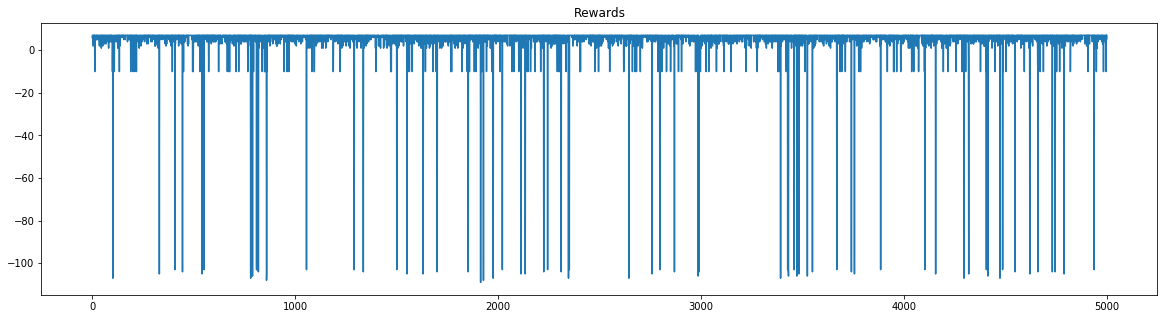

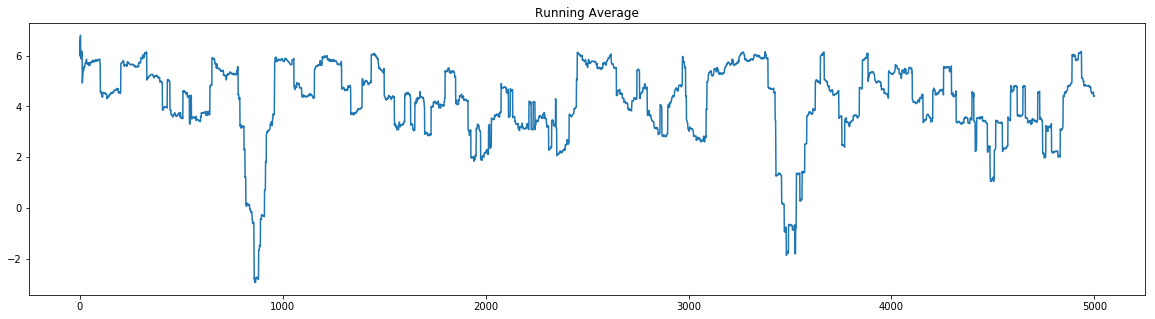

In [15]:
N = 5000
totalrewards = np.empty(N)
for n in range(N):
    if n >= N - 500:
        eps = 0
    else:
        eps = 1.0/np.sqrt(n+1)
        eps=0
    totalreward = play_one(env, model, eps)
    totalrewards[n] = totalreward
    if n % (N/5) == 0:
        print(str(model))

print("avg reward for last 500 episodes:", totalrewards[-500:].mean())

fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(totalrewards)
ax.set_title("Rewards")

plot_running_avg(totalrewards)

# Sequence length 2: Play 5K episodes 25 times and average last 500 mean scores

In [4]:
last500rewards = np.zeros(25)

for epoch in range(25):
    # Reset environment
    env = gym.make('Tiger-v0')
    env.__init__(reward_tiger=-100, reward_gold=10, reward_listen=-1)
    model = QLearnerSeq(env, alpha=.01, gamma=1, seq_len=2)
    eps = 1
    n = 0
    ot = env.reset()

    # Play episodes
    N = 5000
    totalrewards = np.empty(N)
    for n in range(N):
        # For performance measure, don't want to explore.
        if n >= N - 500:
            eps = 0
        else:
            eps = 1.0/np.sqrt(n+1)
        totalreward = play_one(env, model, eps)
        totalrewards[n] = totalreward
    print("avg reward for last 500 episodes:", totalrewards[-500:].mean())
    last500rewards[epoch] = totalrewards[-500:].mean()
    
print('last500rewards avg: ', last500rewards.mean())

avg reward for last 500 episodes: 3.844
avg reward for last 500 episodes: 2.688
avg reward for last 500 episodes: 2.936
avg reward for last 500 episodes: 3.354
avg reward for last 500 episodes: 3.13
avg reward for last 500 episodes: -0.296
avg reward for last 500 episodes: 1.812
avg reward for last 500 episodes: 1.902
avg reward for last 500 episodes: 0.58
avg reward for last 500 episodes: 2.256
avg reward for last 500 episodes: 1.378
avg reward for last 500 episodes: 3.866
avg reward for last 500 episodes: 1.848
avg reward for last 500 episodes: 2.056
avg reward for last 500 episodes: 2.258
avg reward for last 500 episodes: 2.436
avg reward for last 500 episodes: 2.252
avg reward for last 500 episodes: 2.722
avg reward for last 500 episodes: -0.062
avg reward for last 500 episodes: 3.806
avg reward for last 500 episodes: 2.542
avg reward for last 500 episodes: 3.396
avg reward for last 500 episodes: 3.158
avg reward for last 500 episodes: 1.856
avg reward for last 500 episodes: 3.52
l

# Sequence length 3: Play 5K episodes 25 times and average last 500 mean scores

In [5]:
last500rewards = np.zeros(25)

for epoch in range(25):
    # Reset environment
    env = gym.make('Tiger-v0')
    env.__init__(reward_tiger=-100, reward_gold=10, reward_listen=-1)
    model = QLearnerSeq(env, alpha=.01, gamma=1, seq_len=3)
    eps = 1
    n = 0
    ot = env.reset()

    # Play episodes
    N = 5000
    totalrewards = np.empty(N)
    for n in range(N):
        # For performance measure, don't want to explore.
        if n >= N - 500:
            eps = 0
        else:
            eps = 1.0/np.sqrt(n+1)
        totalreward = play_one(env, model, eps)
        totalrewards[n] = totalreward
    print("avg reward for last 500 episodes:", totalrewards[-500:].mean())
    last500rewards[epoch] = totalrewards[-500:].mean()
    
print('last500rewards avg: ', last500rewards.mean())

avg reward for last 500 episodes: 2.186
avg reward for last 500 episodes: 2.076
avg reward for last 500 episodes: 1.768
avg reward for last 500 episodes: 3.512
avg reward for last 500 episodes: 3.338
avg reward for last 500 episodes: 2.568
avg reward for last 500 episodes: 4.668
avg reward for last 500 episodes: 4.86
avg reward for last 500 episodes: 3.57
avg reward for last 500 episodes: 3.696
avg reward for last 500 episodes: 3.858
avg reward for last 500 episodes: 3.49
avg reward for last 500 episodes: 3.026
avg reward for last 500 episodes: 3.654
avg reward for last 500 episodes: 3.048
avg reward for last 500 episodes: 4.616
avg reward for last 500 episodes: 4.008
avg reward for last 500 episodes: 2.96
avg reward for last 500 episodes: 4.168
avg reward for last 500 episodes: 3.732
avg reward for last 500 episodes: 3.364
avg reward for last 500 episodes: 4.886
avg reward for last 500 episodes: 4.682
avg reward for last 500 episodes: 3.968
avg reward for last 500 episodes: 2.88
last5

# Sequence length 4: Play 5K episodes 25 times and average last 500 mean scores

In [6]:
last500rewards = np.zeros(25)

for epoch in range(25):
    # Reset environment
    env = gym.make('Tiger-v0')
    env.__init__(reward_tiger=-100, reward_gold=10, reward_listen=-1)
    model = QLearnerSeq(env, alpha=.01, gamma=1, seq_len=4)
    eps = 1
    n = 0
    ot = env.reset()

    # Play episodes
    N = 5000
    totalrewards = np.empty(N)
    for n in range(N):
        # For performance measure, don't want to explore.
        if n >= N - 500:
            eps = 0
        else:
            eps = 1.0/np.sqrt(n+1)
        totalreward = play_one(env, model, eps)
        totalrewards[n] = totalreward
    print("avg reward for last 500 episodes:", totalrewards[-500:].mean())
    last500rewards[epoch] = totalrewards[-500:].mean()
    
print('last500rewards avg: ', last500rewards.mean())

avg reward for last 500 episodes: 1.716
avg reward for last 500 episodes: 4.102
avg reward for last 500 episodes: 1.954
avg reward for last 500 episodes: 2.35
avg reward for last 500 episodes: 3.19
avg reward for last 500 episodes: 2.566
avg reward for last 500 episodes: 4.076
avg reward for last 500 episodes: 2.91
avg reward for last 500 episodes: 1.426
avg reward for last 500 episodes: 2.65
avg reward for last 500 episodes: 2.704
avg reward for last 500 episodes: 2.768
avg reward for last 500 episodes: 2.846
avg reward for last 500 episodes: 1.732
avg reward for last 500 episodes: 3.132
avg reward for last 500 episodes: 3.428
avg reward for last 500 episodes: 3.334
avg reward for last 500 episodes: 1.172
avg reward for last 500 episodes: 2.866
avg reward for last 500 episodes: 3.056
avg reward for last 500 episodes: 2.072
avg reward for last 500 episodes: 4.054
avg reward for last 500 episodes: 3.304
avg reward for last 500 episodes: 2.764
avg reward for last 500 episodes: 4.518
last

# Sequence length 5: Play 5K episodes 25 times and average last 500 mean scores

In [7]:
last500rewards = np.zeros(25)

for epoch in range(25):
    # Reset environment
    env = gym.make('Tiger-v0')
    env.__init__(reward_tiger=-100, reward_gold=10, reward_listen=-1)
    model = QLearnerSeq(env, alpha=.01, gamma=1, seq_len=5)
    eps = 1
    n = 0
    ot = env.reset()

    # Play episodes
    N = 5000
    totalrewards = np.empty(N)
    for n in range(N):
        # For performance measure, don't want to explore.
        if n >= N - 500:
            eps = 0
        else:
            eps = 1.0/np.sqrt(n+1)
        totalreward = play_one(env, model, eps)
        totalrewards[n] = totalreward
    print("avg reward for last 500 episodes:", totalrewards[-500:].mean())
    last500rewards[epoch] = totalrewards[-500:].mean()
    
print('last500rewards avg: ', last500rewards.mean())

avg reward for last 500 episodes: 1.994
avg reward for last 500 episodes: 2.04
avg reward for last 500 episodes: 4.226
avg reward for last 500 episodes: 4.896
avg reward for last 500 episodes: 2.622
avg reward for last 500 episodes: 2.24
avg reward for last 500 episodes: 2.442
avg reward for last 500 episodes: 3.49
avg reward for last 500 episodes: 3.034
avg reward for last 500 episodes: 1.704
avg reward for last 500 episodes: 2.956
avg reward for last 500 episodes: 1.292
avg reward for last 500 episodes: 3.158
avg reward for last 500 episodes: 1.458
avg reward for last 500 episodes: 1.068
avg reward for last 500 episodes: 2.138
avg reward for last 500 episodes: 4.656
avg reward for last 500 episodes: 0.87
avg reward for last 500 episodes: 3.528
avg reward for last 500 episodes: 3.692
avg reward for last 500 episodes: 1.554
avg reward for last 500 episodes: 2.7
avg reward for last 500 episodes: 2.098
avg reward for last 500 episodes: 0.484
avg reward for last 500 episodes: 2.208
last50

# Sequence length 6: Play 5K episodes 25 times and average last 500 mean scores

In [10]:
last500rewards = np.zeros(25)

for epoch in range(25):
    # Reset environment
    env = gym.make('Tiger-v0')
    env.__init__(reward_tiger=-100, reward_gold=10, reward_listen=-1)
    model = QLearnerSeq(env, alpha=.01, gamma=1, seq_len=6)
    eps = 1
    n = 0
    ot = env.reset()

    # Play episodes
    N = 5000
    totalrewards = np.empty(N)
    for n in range(N):
        # For performance measure, don't want to explore.
        if n >= N - 500:
            eps = 0
        else:
            eps = 1.0/np.sqrt(n+1)
        totalreward = play_one(env, model, eps)
        totalrewards[n] = totalreward
    print("avg reward for last 500 episodes:", totalrewards[-500:].mean())
    last500rewards[epoch] = totalrewards[-500:].mean()
    
print('last500rewards avg: ', last500rewards.mean())

avg reward for last 500 episodes: -1.708
avg reward for last 500 episodes: -1.9
avg reward for last 500 episodes: -1.31
avg reward for last 500 episodes: -3.308
avg reward for last 500 episodes: -4.764
avg reward for last 500 episodes: -1.906
avg reward for last 500 episodes: -0.574
avg reward for last 500 episodes: -4.876
avg reward for last 500 episodes: -1.45
avg reward for last 500 episodes: -5.822
avg reward for last 500 episodes: -0.378
avg reward for last 500 episodes: -2.07
avg reward for last 500 episodes: -4.338
avg reward for last 500 episodes: -1.96
avg reward for last 500 episodes: 0.51
avg reward for last 500 episodes: -2.91
avg reward for last 500 episodes: -3.008
avg reward for last 500 episodes: 0.116
avg reward for last 500 episodes: -5.164
avg reward for last 500 episodes: -3.776
avg reward for last 500 episodes: -1.734
avg reward for last 500 episodes: -2.912
avg reward for last 500 episodes: -3.518
avg reward for last 500 episodes: -0.432
avg reward for last 500 ep